# Project: Geometric Brownian Motion (GBM) Models and Stylized Facts
Geometric Brownian motion (GBM) is widely used as a pricing model. However, whether GBM replicates many of the statistical properties of actual pricing and return data is unclear. 
* These properties, referred to as _stylized facts_ have been observed for decades, dating back to early work by [Mandelbrot](https://en.wikipedia.org/wiki/Benoit_Mandelbrot) and later in several studies by [Rama Cont](http://rama.cont.perso.math.cnrs.fr/pdf/empirical.pdf) and more recently by [Ratliff-Crain et al.](https://arxiv.org/abs/2311.07738) who reviewed the 11 original stylized facts proposed by [Cont](http://rama.cont.perso.math.cnrs.fr/pdf/empirical.pdf) with newer data.

## Learning objectives
In this project, students will examine a few of the statistical properties (stylized facts) of return data and explore how well geometric Brownian motion models replicate these properties. 

* __Prerequisite__: Load and clean the historical dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) between `01-03-2018` and `12-29-2023`.
* __Objective 1__: Are the returns in dataset $\mathcal{D}$ actually Laplace distributed?
    * `TODO`: Estimate the return data for firms in dataset $\mathcal{D}$
    * `TODO`: Classify the returns of firm $i$ as $c_{i}\in\left\{\text{normal},\text{laplace},\text{undefined}\right\}$
* __Objective 2__: Does geometric Brownian motion replicate common stylized facts?
    * `TODO`: Compute the return distribution predicted by a GBM model analytical solution and Monte Carlo simulation
        * `Check`: Are the analytical and Monte Carlo returns drawn from the same distribution?
        * `Discussion`: how do our choices influence the results of comparison between analytical and numerical simulation of the returns?
    * `TODO`: Test the autocorrelation of GBM model returns and the returns computed from observed market prices

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.

In [3]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-2/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `12-29-2023`, along with data for a few exchange-traded funds and volatility products during that time. 
* We load the `orignal_dataset` by calling the `MyMarketDataSet()` function and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ is stored in the `dataset` variable, where the dataset $\mathcal{D}$ has data for $\mathcal{L}$ firms, held in the `list_of_all_firms` variable.

In [5]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [9]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Then, get a list of firms that we have in the cleaned-up `dataset` and save it in the `list_of_all_firms` array (we sort these alphabetically):

In [11]:
list_of_all_firms = keys(dataset) |> collect |> sort;

Finally, we set some constant values that are used throughout the study. In particular, the value of $\Delta{t}$ holds the time step that we'll use (see below for a discussion of the value):

In [13]:
Δt = (1.0/252.0);

## Objective 1: Are the returns in dataset $\mathcal{D}$ Laplace distributed?
One of the central stylized facts is that return distributions have `fat tails,` i.e., the density of the returns near zero is smaller than a normal distribution, with more density on the tails of the distribution. 
* In the example for this module, we showed that only a small fraction of returns actually followed a normal distribution. However, while we suggested an alternative `Laplace` distribution for most firms in dataset $\mathcal{D}$, we did not quantitatively test this assertion.

Let's develop a procedure based on the [Anderson–Darling test](https://en.wikipedia.org/wiki/Anderson–Darling_test) and [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) exported by the [HypothesisTests.jl package](https://github.com/JuliaStats/HypothesisTests.jl) to estimate which firms in the dataset $\mathcal{D}$ follow a [Laplace distribution](https://en.wikipedia.org/wiki/Laplace_distribution)

### TODO: Estimate the return data for firms in dataset $\mathcal{D}$.
Compute the log growth rates for the firms in the `list_of_all_firms` $\mathcal{L}$ using the `log_return_matrix(...)` function.
* The `log_return_matrix(...)` takes `dataset` $\mathcal{D}$ and a list of firms $\mathcal{L}$ and computes the growth rate values for each firm as a function of time. The data is returned as a $\mathcal{D}_{i}\times\dim\mathcal{L}$ array (time on the rows, firm $i$ on the columns). We store the data in the `log_growth_array` variable:

In [16]:
log_growth_array = log_return_matrix(dataset, list_of_all_firms);

### TODO: Classify the returns of firm $i$ as $c_{i}\in\left\{\text{normal},\text{laplace},\text{undefined}\right\}$
Suppose we define the class set $\mathcal{C}\equiv\left\{\text{normal},\text{laplace},\text{undefined}\right\}$ to describe the possible types of returns. Classify the shape of the returns for each of the firms in the `dataset` $\mathcal{D}$, where for each firm $i$ we compute a classification $c_{i}\in\left\{\text{normal},\text{laplace},\text{undefined}\right\}$. For each statistical test, use a `pvalue = 0.0001` cutoff.
* `Normal`: Test for normality of the return for firm $i$ using a one-sample [Anderson–Darling test](https://en.wikipedia.org/wiki/Anderson–Darling_test).
* `Laplace`: If the return for firm $i$ is `NOT` normal, use a one-sample [Kolmogorov-Smirnov test](https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test) and a one-sample [Anderson–Darling test](https://en.wikipedia.org/wiki/Anderson–Darling_test) to determine if the return for firm $i$ follows a `Laplace` distribution. 
* `Undefined`: If both the tests fail, classify firm $i$ as `undefined`.

In [18]:
return_classification_dictionary = Dict{String, Symbol}();
p_value_cutoff = 0.00001;
for i ∈ eachindex(list_of_all_firms)
    
    ticker = list_of_all_firms[i];
    samples = log_growth_array[:,i];
    
    d_normal = fit_mle(Normal, samples)
    d_laplace = fit_mle(Laplace, samples)

    AD_test_result = OneSampleADTest(samples,d_normal) |> pvalue
    if (AD_test_result > p_value_cutoff) # support H0
        return_classification_dictionary[ticker] = :normal
    else
        KS_test_result_laplace = ExactOneSampleKSTest(samples, d_laplace) |> pvalue
        AD_test_result_laplace = OneSampleADTest(samples,d_laplace) |> pvalue
        if (KS_test_result_laplace > p_value_cutoff && AD_test_result_laplace > p_value_cutoff)
            return_classification_dictionary[ticker] = :laplace
        else
            return_classification_dictionary[ticker] = :undefined
        end
    end
end
return_classification_dictionary;

┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/r322N/src/kolmogorov_smirnov.jl:68
┌ Warning: This test is inaccurate with ties
└ @ HypothesisTests ~/.julia/packages/HypothesisTests/r322N/src/kolmogorov_smirnov.jl:68


#### What is the fraction of `normal`, `laplace` or `undefined`?

In [20]:
fraction_normal = findall(x->x==:normal, return_classification_dictionary) |> length |> 
    x -> x/length(list_of_all_firms) |> x-> round(x,digits=3) |> x-> *(x,100.0)
println("Approximately $(fraction_normal)% of the firms in the dataset have Normally distributed returns")

Approximately 8.3% of the firms in the dataset have Normally distributed returns


In [21]:
fraction_laplace = findall(x->x==:laplace, return_classification_dictionary) |> length |> 
    x -> x/length(list_of_all_firms) |> x-> round(x,digits=3) |> x-> *(x,100.0)
println("Approximately $(fraction_laplace)% of the firms in the dataset have Laplace distributed returns")

Approximately 91.7% of the firms in the dataset have Laplace distributed returns


In [22]:
fraction_undefined = findall(x->x==:undefined, return_classification_dictionary) |> length |> 
    x -> x/length(list_of_all_firms) |> x-> round(x,digits=3) |> x-> *(x,100.0)
println("Approximately $(fraction_undefined)% of the firms in the dataset have undefined returned distributions")

Approximately 0.0% of the firms in the dataset have undefined returned distributions


## Objective 2: Does geometric Brownian motion replicate common stylized facts?
In our example, a GBM model could capture price information (or at least possible price ranges) depending on the firm and the time window selected. However, price is not the only feature we may be interested in. Let's see if a GBM model predicts the shape of the return distribution and the relationship between current and past returns, i.e., the [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) of the returns.

* First, let's select a ticker from the `list_of_all_firms` array and store your favorite ticker in the `my_favorite_ticker` variable:

In [24]:
my_favorite_ticker = "AMD";

### TODO: Compute the return distribution analytically and by Monte-Carlo simulation
Now that we have specified a ticker let's compute the return distribution. From the analytical solution of the geometric Brownian motion (GBM) equation, we can see that GBM will _not_ admit Laplace distributed returns, i.e., the returns will follow a normal distribution. The return for a GBM model is given by:
$$
\begin{equation}
r_{t,\circ}\equiv\ln\left(\frac{S_{t}}{S_{\circ}}\right) = \Biggl[\left(\mu-\frac{\sigma^{2}}{2}\right)\Delta{t} + (\sigma\sqrt{\Delta{t}})\cdot{Z_{t}(0,1)}\Biggr]
\end{equation}
$$
where $\Delta{t}=t - t_{\circ}$. This expression is a normal distribution with mean $\left(\mu-\frac{\sigma^{2}}{2}\right)\Delta{t}$ and variance $\sigma^{2}\Delta{t}$. Let's compute the return distribution for `my_favorite_ticker`.

* Load the $(\hat{\mu},\hat{\sigma})$ dataset we computed in the example for this module and select the parameter for `my_favorite_ticker.` We'll store these in the `my_parameters` variable which is type [DataFrameRow](https://dataframes.juliadata.org/stable/lib/types/#DataFrames.DataFrameRow):

In [26]:
parameters_df = CSV.read(joinpath(_PATH_TO_DATA,"Parameters-SP500-2018-2023.csv"), DataFrame);
my_parameters = findfirst(x->x==my_favorite_ticker, parameters_df[:,:ticker]) |> i-> parameters_df[i,:]

Row,ticker,drift,volatility
,String7,Float64,Float64
27,AMD,0.371691,0.459735


#### Analytical return model
Start by constructing an `analytical` model of the return for `my_favorite_ticker`. To select $(\hat{\mu},\hat{\sigma})$ values from a [DataFrameRow](https://dataframes.juliadata.org/stable/lib/types/#DataFrames.DataFrameRow), we simply pass in the column name as a [Symbol](https://docs.julialang.org/en/v1/manual/metaprogramming/#Symbols). Select the `drift` and `volatility` values:

In [28]:
μ̂ = my_parameters[:drift];
σ̂ = my_parameters[:volatility];

Now construct an `analytical` return model by constructing a Normal distribution with the proper mean and standard deviation using the [Normal function](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.Normal) exported by the [Distributions.jl package](https://github.com/JuliaStats/Distributions.jl). Store this model in the `return_analytical_model` variable:

In [30]:
return_analytical_model = Normal((μ̂ - (σ̂^2)/2) ,σ̂)

Normal{Float64}(μ=0.26601331677664725, σ=0.4597348454541331)

#### Monte-Carlo simulation
We could also construct the return distribution by sampling, using Monte-Carlo simulation and the geometric Brownian motion model. Assume we start on the first trading day of `2023` and simulate until the end of `2023`. Get the actual data for `my_favorite_ticker` from the `dataset` using the [filter function from the DataFrame package](https://juliadatascience.io/filter_subset). 
* The selection condition we'll use is to find `:timestamps` after `Jan 01, 2023`. Store this data (which is a `DataFrame` holding only `2023` data) in the `my_price_dataset` variable. This data will have `T` rows (number of trading days in `2023`).

In [32]:
my_price_dataset = dataset[my_favorite_ticker] |> x-> filter(:timestamp => y -> y ≥ Date(2023,01,01), x);

Now build an instance of the [MyGeometricBrownianMotionEquityModel](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyGeometricBrownianMotionEquityModel) using a [build function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}), where you pass in values for the $(\hat{\mu},\hat{\sigma})$ parameters as arguments to the [build function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.build-Tuple{Type{MyGeometricBrownianMotionEquityModel},%20NamedTuple}). Store this in the `model` variable:

In [34]:
model = build(MyGeometricBrownianMotionEquityModel, (
            μ = μ̂, σ = σ̂ ));

To simulate the GBM model, we need to specify the `number_of_samples`, i.e., the number of trajectories to compute, the initial share price `Sₒ`, the initial time `T₁`, the final time `T₂`. Pass these (along with your `model` instance) into the [sample function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyGeometricBrownianMotionEquityModel,%20NamedTuple}). 
* The [sample function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.sample-Tuple{MyGeometricBrownianMotionEquityModel,%20NamedTuple}) generates `number_of_samples` possible price trajectories from $T_{1}\rightarrow{T}_{2}$ using the GBM `model` instance. The simulation data is returned as an array, where the first column in the time and columns `2:end` hold simulated trajectories. Store this in the variable `X`

In [36]:
number_of_samples = 10000;
Sₒ = my_price_dataset[1, :volume_weighted_average_price];
T₁ = 0*Δt
T₂ = (nrow(my_price_dataset)-1)*Δt
X = VLQuantitativeFinancePackage.sample(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
    number_of_paths = number_of_samples);

Finally, from the simulation data `X` let's compute the return $r_{t,t-1} = \ln\left(S_{t}/S_{t-1}\right)$ for each trajectory in `X` and store the `return_numerical_model::Array{Float64,1}` using the [push! function in Julia](https://docs.julialang.org/en/v1/base/collections/#Base.push!):

In [38]:
return_numerical_model = Array{Float64,1}()
for i ∈ 1:number_of_samples
    Sₒ = X[1,i+1];
    S₁ = X[end,i+1];
    r = log(S₁/Sₒ)
    push!(return_numerical_model,r)
end

`Unhide` the code block below to see how we visualized the `analytical` and `numerical` return distributions. 

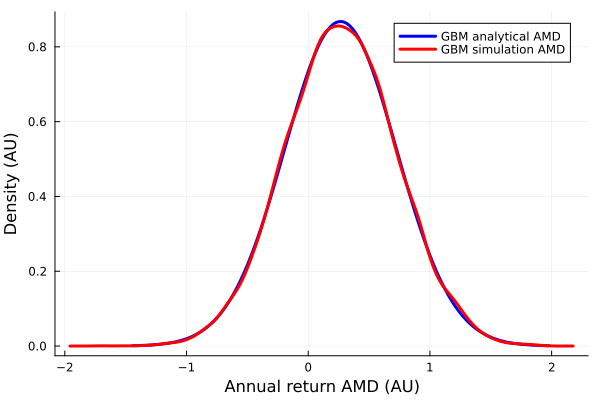

In [40]:
plot(return_analytical_model, label="GBM analytical $(my_favorite_ticker)", lw=3, c=:blue)
density!(return_numerical_model, label="GBM simulation $(my_favorite_ticker)",lw=3, c=:red)
xlabel!("Annual return $(my_favorite_ticker) (AU)",fontsize=18)
ylabel!("Density (AU)", fontsize=18)

#### Check: Are the analytical and Monte Carlo returns drawn from the same distribution?
GBM returns for firm $i$, whether calculated using the analytical solution or by Monte Carlo simulation, will always be Normally distributed. Thus, if $c_{i}\neq\text{normal}$, then the model _fails_ to capture the actual shape of the returns. However, another question is whether the analytical solution and the Monte Carlo approach produce returns from the _same distribution_. 

Let's develop an approach to answer this question using the [One-sample Anderson Darling test](https://juliastats.org/HypothesisTests.jl/stable/nonparametric/#HypothesisTests.OneSampleADTest) exported by the [HypothesisTests.jl package](https://github.com/JuliaStats/HypothesisTests.jl).
* The `H0:null hypothesis` is that the returns from the analytical model and the Monte Carlo simulation are drawn from the same distribution. The `H1:alternative` hypothesis is that they are drawn from different distributions. We `reject H0` if `pvalue`$\leq$`p_value_cutoff`.

In [42]:
onesample_AD_test_result = OneSampleADTest(return_numerical_model, return_analytical_model)

One sample Anderson-Darling test
--------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: fail to reject h_0
    one-sided p-value:           0.8260

Details:
    number of observations:   10000
    sample mean:              0.26912595604908107
    sample SD:                0.4564937578767829
    A² statistic:             0.422631584143461


#### Discussion questions
1. Does the `number_of_samples` influence the agreement between the analytical return distribution and the return distribution created by Monte Carlo simulations?
2. How would you develop a procedure that compares the return distribution shape if we used the [K-sample Anderson-Darling test](https://juliastats.org/HypothesisTests.jl/stable/nonparametric/#HypothesisTests.KSampleADTest) instead of the [One-sample Anderson Darling test](https://juliastats.org/HypothesisTests.jl/stable/nonparametric/#HypothesisTests.OneSampleADTest)?

### TODO: Test the autocorrelation of GBM model returns
Another important stylized fact is the lack of autocorrelation of the returns. Let's compute the autocorrelation of the _daily_ returns from the data and compare that to the _daily_ autocorrelation computed using geometric Brownian motion.
* __Hypothesis__: Geometric Brownian motion is a type of random walk, i.e., a random walk with drift. Thus, the autocorrelation of the returns computed from a GBM model should be close to zero. On the other hand, the actual return data for `my_favorite_ticker` should also follow a random walk, suggesting stock returns are random, a key tenet of the [efficient market hypothesis](https://en.wikipedia.org/wiki/Efficient-market_hypothesis)

Let's construct the _daily_ return from the simulation array `X`, and store these values in the `daily_return_array_GBM` variable, where the `T-1` rows correspond to time, and the `number_of_samples` columns hold the return values $r_{t,t-1}$ where the time step is a single trading day.

In [45]:
daily_return_array_GBM = Array{Float64,2}(undef, nrow(my_price_dataset)-1, number_of_samples)
for i ∈ 1:number_of_samples
    for k ∈ 2:nrow(my_price_dataset)
        Sₒ = X[k-1,i+1];
        S₁ = X[k,i+1];
        daily_return_array_GBM[k-1,i] = log(S₁/Sₒ);
    end
end
daily_return_array_GBM;

* Next, we can compute the _daily_ return from the observed market data using the `log_return_matrix(...)` function. We store the data in the `daily_return_array_data` array, where `daily_return_array_data` has `T-1` rows and a single column: 

In [47]:
daily_return_array_data = log_return_matrix(Dict(my_favorite_ticker=>my_price_dataset), 
    [my_favorite_ticker], testfirm=my_favorite_ticker, Δt = 1.0);

Finally, let's compute the [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) using the [autocor function](https://juliastats.org/StatsBase.jl/stable/signalcorr/#StatsBase.autocor) exported by the [StatsBase.jl package](https://github.com/JuliaStats/StatsBase.jl). 
* First, compute the length $L$ of the data, in this case `daily_return_array_data` which should be `L = T - 1`.
* Next, we compute the lag range and store this in the `τ` variable.
* Lastly, compute the autocorrelation for the GBM model returns (stored in the `AC_model` variable) and from the observed market price (stored in the `AC_data` variable).

In [49]:
L = length(daily_return_array_data);
τ  = range(0,step=1,stop=(L-1));
AC_model = autocor(daily_return_array_GBM[:,1], τ); # function provided by the StatsBase package
AC_data = autocor(daily_return_array_data, τ); # function provided by the StatsBase package

`Unhide` the code block below to see how we visualize the autocorrelation computed from the model, and the prices observed in the market. 

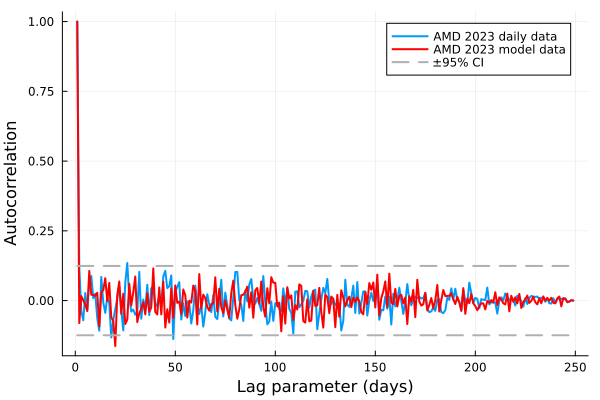

In [51]:
Δ = 1.96/sqrt(L)
plot(AC_data, lw=2, label="$(my_favorite_ticker) 2023 daily data")
plot!(AC_model, lw=2, c=:red,label="$(my_favorite_ticker) 2023 model data")
plot!(Δ*ones(L),lw=2,c=:gray69,ls=:dash, label="±95% CI")
plot!(-Δ*ones(L),lw=2,c=:gray69,ls=:dash, label="")
xlabel!("Lag parameter (days)",fontsize=18)
ylabel!("Autocorrelation", fontsize=18)

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.